# Pulse stream recovery under additive noise

In the previous notebooks, we considered the pulse stream recovery problem under no noise. Here we investigate the effect of **_additive_** noise on our recovery process. Moreover, we consider:

\begin{align}
y_{meas}[n] = y_{BL}[n] = w[n],   \nonumber
\end{align}

where $w[n]$ can be modelled as additive white Gaussian noise with variance $\sigma^2$.

In [1]:
import numpy as np
import plot_settings
import sys
sys.path.append('..')

from frius import create_pulse_param, sample_ideal_project, estimate_fourier_coeff, compute_ann_filt, estimate_time_param, estimate_amplitudes, evaluate_recovered_param
from frius import add_noise  # 'us_utils.py'

# 1. Oversampling

Our first "mechanism" to deal with noise is to **_oversample_**. This is not too different from the classical bandlimited situation in which a particular choice for the bandwidth may be too "restrictive" as an approximation of our original signal. Therefore, in order to reduce this _approximation error_, i.e. represent our original signal more faithfully as a bandlimited signal, we may need to 1) increase the bandwidth of our anti-aliasing filter / generation function and 2) increase the sampling rate (i.e. take more samples per unit of time).

These two steps are precisely what will be done for the pulse stream scenario _prior_ to applying a denoising algorithm.

# 2. Exploiting redundancy in extra measurements

Assuming that we are correct in our choice of the number of pulses $K$, oversampling, i.e. taking $N\geq 2K+1$ samples, would yield more measurements than degrees of freedom in the noiseless case: $\rho = 2K$. Under noise, more than $2K$ degrees of freedom are needed to represent our signal. Therefore, it is natural that we need more samples.

For the pulse stream recovery problem, we will define an oversampling factor $\beta > 1$ so that an _integer_ number of samples $N$ is given by:

\begin{align}
N = 2\beta K +1.  \nonumber
\end{align}

As a reminder, we need an odd number of measurements ($2K+1$ for critical sampling) in order to use real-valued sampling kernels.

We inevitably have to bring in some more math now to see how we can exploit the redundancy in our extra measurements. In the last notebook, in particular in the Appendix, we saw in more detail what the annihilation filter entailed, namely the discrete convolution between the (equalized) Fourier coefficients and this filter is equal to zero for all indices. We can write this annihilation property (or constraint within the context of denoising) as a matrix-vector product:

\begin{align}
\begin{bmatrix} 
\hat{x}[\mathrel{{-M}{+}{K}}]&\hat{x}[\mathrel{{-M}{+}{K}{-}{1}}] & \cdots & \hat{x}[-M]\\
\vdots&\ddots &  \ddots & \vdots\\
\hat{x}[1] & \hat{x}[0] &   \cdots & \hat{x}[\mathrel{{-K}{+}{1}}] \\ 
\hat{x}[2] & \hat{x}[1] &  \cdots & \hat{x}[\mathrel{{-K}{+}{2}}] \\ 
\vdots&\vdots& \ddots & \vdots\\
\hat{x}[M] & \hat{x}[\mathrel{{M}{-}{1}}]  & \cdots & \hat{x}[\mathrel{{M}{-}{K}}]
\end{bmatrix}  
\underbrace{\begin{bmatrix} a[0] \\ a[1] \\ a[2] \\ \vdots\\ a[K]\end{bmatrix}}_{\mathbf{a}}
&=
\mathbf{0}. \nonumber
\end{align}

One thing to notice about the matrix of Fourier coefficients ($\hat{x}[n]$) above is its [**_Toeplitz_**](https://en.wikipedia.org/wiki/Toeplitz_matrix) structure, i.e. descending diagonals from left to right are constant. We can write the above annihilation constraint more concisely as:

\begin{align}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) \hspace{0.05cm}\mathbf{a} = \mathbf{0},   \nonumber
\end{align}

where the operator $ \mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) $ forms the Toeplitz matrix from $ \mathbf{\hat{x}} = \{\hat{x}[m]\}_{m=-M}^{M} $ with $ (K+1 )$ columns.

If there are truly $K$ pulses, another (less intuitive) observation we can make about the matrix $ \mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) $ is that it has a rank of at most $K$. In the [Appendix](#app) of this notebook, we prove this rank property. With our extra measurements, we can then exploit this rank property for recovery under noise!

## Total least-squares (TLS)

The simplest "denoising" scheme, although it is more akin to parameter extraction, is to perform the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (SVD) of the Toeplitz matrix:

\begin{align}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})  = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^H, \nonumber
\end{align}

where $ \mathbf{\Sigma} \in \mathbb{C}^{(2M+1-K)\times(K+1)} $ is a rectangular diagonal matrix of singular values in _decreasing order_ along the diagonal, $ \mathbf{U}\in \mathbb{C}^{(2M+1-K)\times(2M+1-K)} $ is a [unitary](https://en.wikipedia.org/wiki/Unitary_matrix) matrix, and $ \mathbf{V}\in\mathbb{C}^{(K+1)\times(K+1)} $ is another unitary matrix. Since $ \text{rank}\big(\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) \big)=K $ for noiseless Fourier coefficients, the $ (K+1)^{th} $ singular value along the diagonal of $ \mathbf{\Sigma} $ should ideally be equal to zero!

We can write this as:

\begin{align}
\sigma_{K+1}\big(\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) \big) = 0, \nonumber
\end{align}

where $ \sigma_K(\mathbf{A}) $ denotes the $ K^{th} $ largest singular value of $ \mathbf{A} $. Therefore, the <a href="https://en.wikipedia.org/wiki/Kernel_(linear_algebra)">**_null space_**</a> of $ \mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})  $ is spanned by the $ (\mathrel{{K}{+}{1}})^{th} $ column of $ \mathbf{V} $, i.e. the last column. 

Mathematically, this implies:

\begin{equation}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})\hspace{0.05cm}\mathbf{V}_{(-1)} = \mathbf{0}, \nonumber
\end{equation}

where $ \mathbf{V}_{(-1)}$ extracts the last column of $ \mathbf{V} $. This means that $  \mathbf{V}_{(-1)} $ meets the annihilation constraint we saw earlier: $\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) \hspace{0.05cm}\mathbf{a} = \mathbf{0}$.

However, _noisy_ Fourier coefficients $ \mathbf{\hat{x}}_{noisy} $ estimated from the measured samples will typically result in a Toeplitz matrix $ \mathbf{T}(\mathbf{\hat{x}}_{noisy}, \mathrel{{K}{+}{1}} ) $ with a rank larger than $ K $. Therefore, the $ (\mathrel{{K}{+}{1}})^{th} $ singular value of $ \mathbf{T}(\mathbf{\hat{x}}_{noisy}, \mathrel{{K}{+}{1}} )$ may not be equal to zero. Nonetheless, if this singular value is significantly smaller than the $ K^{th} $ singular value, $ \mathbf{V}_{(-1)} $ may still be a sufficient candidate for the annihilating filter.

This method for obtaining the annihilating filter with the SVD is often called the **_total least-squares approach_** and abbreviated as TLS. It was first suggested within the context of FRI in [1].
 
Let's see how this approach works with synthetic data! We will consider additive white Gaussian noise at various _signal-to-noise ratio_ (SNR) values. The variance of the noise will be set according to the signal energy and the desired SNR in dB. Please refer the function `'add_noise'` in `'frius/us_utils.py'` for the implementation details.

# 3. Simulations

We first consider critical sampling and recovery as seen in the previous notebooks for the noiseless case _but_ with noisy samples.

||tk - tk_hat||_2 = 0.067730 
||ck - ck_hat||_2 = 2.265625 


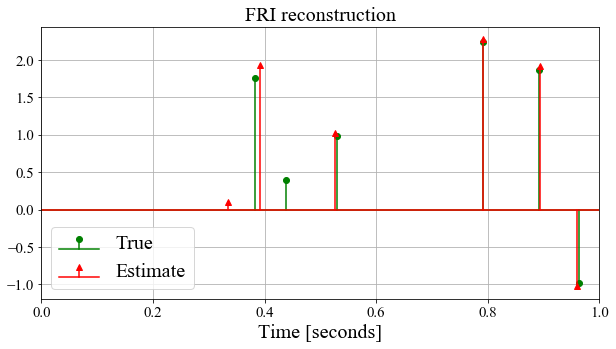

In [23]:
# signal parameters
K = 6
period = 1
ck, tk = create_pulse_param(K=K, period=period)

# critical sampling
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period)

# add noise
snr_db = 50
y_noisy = add_noise(y_samp, snr_db=snr_db)

# recovery
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
ann_filt = compute_ann_filt(fs_coeff_hat, K)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

With critical sampling, we can see that we completely miss out on one of the Diracs around $0.45$ seconds and are a little bit off for the Dirac around $0.4$ seconds.

With the same signal parameters and SNR, we will oversample the FRI by a factor of $\beta = 2$ and apply the TLS approach described above.

K/(K+1) singular value = 22.675217

||tk - tk_hat||_2 = 0.001114 
||ck - ck_hat||_2 = 0.010277 


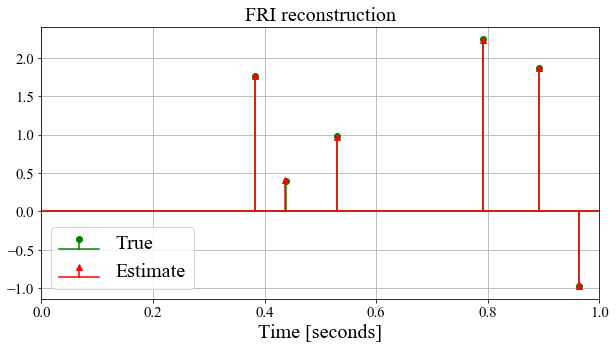

In [25]:
from scipy.linalg import toeplitz, svd

def total_least_squares(fs_coeff, K):
    col1 = fs_coeff[K:]
    row1 = np.flipud(fs_coeff[:K+1])
    A_top = toeplitz(col1, r=row1)
    U, s, Vh = svd(A_top)
    print("K/(K+1) singular value = %f\n" % (s[K-1]/s[K]))
    return np.conj(Vh[-1, :]) 

    
oversample_freq = 2
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# add noise
y_noisy = add_noise(y_samp, snr_db=snr_db)

# recovery
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
ann_filt = total_least_squares(fs_coeff_hat, K)
# ann_filt = compute_ann_filt(fs_coeff_hat, K, print_ratio=True)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

And we are able to obtain the pulse parameters quite well! 

It is also possible to use the same function `'compute_ann_filt'` from `'frius/fri_utils.py'`, as it will detect if we are in a scenario where we have more Fourier coefficients than $(2K+1)$ and apply TLS if it is the case.

# More noise!

An SNR of $50$ dB corresponds to very little noise. Below we plot the clean and noisy samples from our critical sampling scenario.

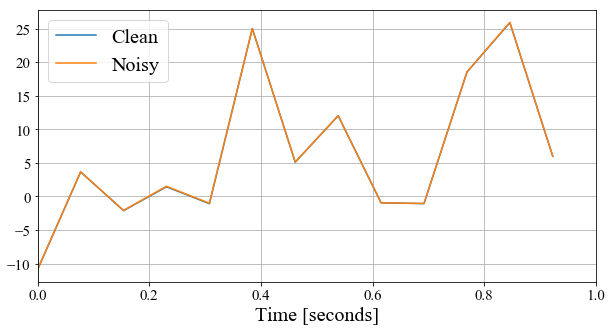

In [27]:
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period)

# add noise
snr_db = 50
y_noisy = add_noise(y_samp, snr_db=snr_db)

# visualize
plt.figure(figsize=(10,5))
plt.plot(t_samp, y_samp, label="Clean")
plt.plot(t_samp, y_noisy, label="Noisy")
plt.xlabel("Time [seconds]")
plt.xlim([0, period])
plt.grid()
plt.legend();

The two signals are practically identical! This reflects the very sensitive behavior of the recovery algorithm even to the _slightest_ perturbation. Let's try a smaller SNR, i.e. one that will result in a noticeable perturbation of the clean samples, and with an oversampling factor of $\beta= 7$. Generally, with more noise, we will need to oversample by a larger factor.

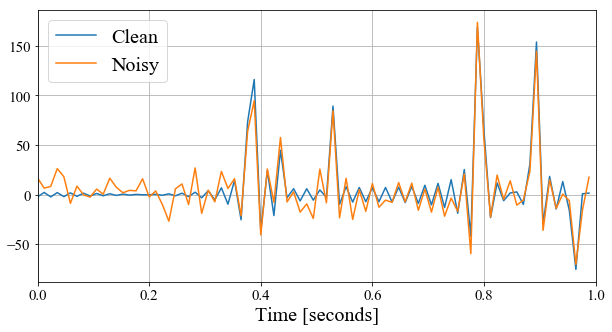

In [31]:
oversample_freq = 7
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# add noise
snr_db = 10
y_noisy = add_noise(y_samp, snr_db=snr_db)

# visualize
plt.figure(figsize=(10,5))
plt.plot(t_samp, y_samp, label="Clean")
plt.plot(t_samp, y_noisy, label="Noisy")
plt.xlabel("Time [seconds]")
plt.xlim([0, period])
plt.grid()
plt.legend();

And now let's try recovering the pulse parameters.

K/(K+1) singular value = 1.341383

||tk - tk_hat||_2 = 0.140494 
||ck - ck_hat||_2 = 2.881176 


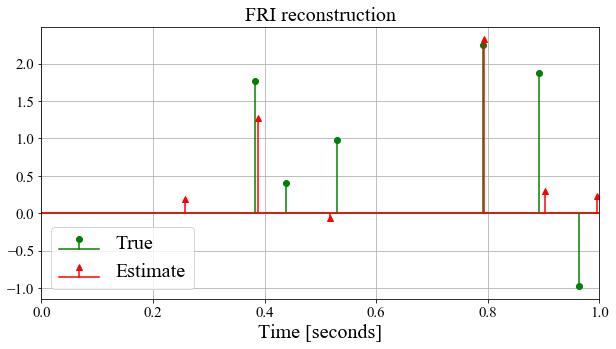

In [32]:
# recovery
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
ann_filt = compute_ann_filt(fs_coeff_hat, K, print_ratio=True)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

Not so great, but we can also notice that the ratio between the $K^{th}$ and $ (\mathrel{{K}{+}{1}})^{th} $ singular value is considerably smaller ($1.34$ compared to $22.7$).

If we increase the oversampling factor to $\beta=10$, we are able to perform a better recovery. However, we still miss out on one Dirac, and the singular value ratio is still not desirable to represent a low rank matrix that we are expecting.

K/(K+1) singular value = 1.181130

||tk - tk_hat||_2 = 0.185721 
||ck - ck_hat||_2 = 2.330230 


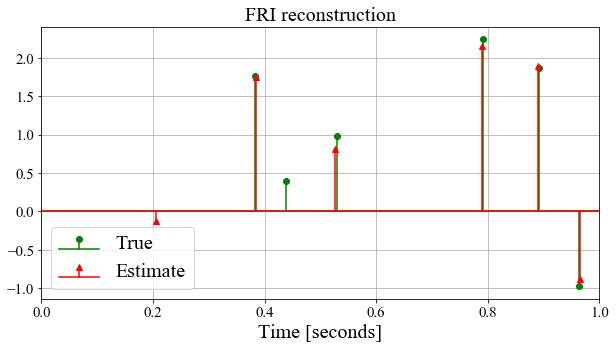

In [33]:
oversample_freq = 10
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# add noise
y_noisy = add_noise(y_samp, snr_db=snr_db)

# recovery
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
ann_filt = compute_ann_filt(fs_coeff_hat, K, print_ratio=True)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

This diffulty for lower SNRs motivates another denoising approach, which we will consider in the following notebook, called **_Cadzow's iterative denoising_**. It is also suggested by [1] and again exploits the low rank property of the Toeplitz matrix of Fourier coefficient in order to perform a "model matching" step prior to TLS.

As a small teaser, below we employ Cadzow's iterative denoising to (quite) sucessfully recovery the pulse parameters for an oversampling factor of $\beta=7$.

K/(K+1) singular value = 116.724940

||tk - tk_hat||_2 = 0.004088 
||ck - ck_hat||_2 = 0.400618 


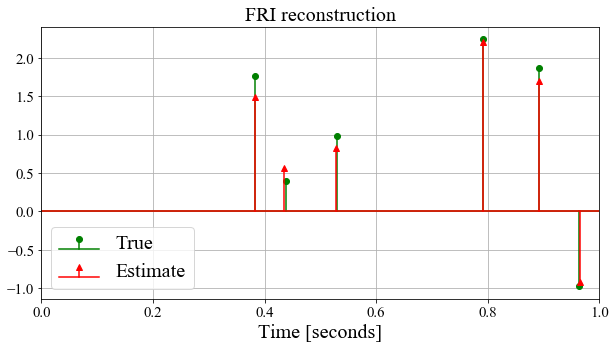

In [34]:
from frius import cadzow_denoising

oversample_freq = 7
snr_db = 10
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, oversample_freq=oversample_freq)

# add noise
y_noisy = add_noise(y_samp, snr_db=snr_db)

# recovery
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_noisy, t_samp)
fs_coeff_hat = cadzow_denoising(fs_coeff_hat, K, n_iter=2)
ann_filt = compute_ann_filt(fs_coeff_hat, K, print_ratio=True)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, figsize=(10,5), t_max=period)
plt.legend(loc="lower left");

That's certainly a more representation singular value ratio for a Toeplitz matrix with rank $K$!

<a id='app'></a>
# Appendix: Rank of Toeplitz matrix from pulse stream Fourier coefficients

Assuming that we are correct in our choice of $ K $ pulses and that we have obtained noiseless Fourier coefficients $ \{\hat{x}[m]\}_{m=-M}^{M} $  for  $ M \geq K $, the rectangular Toeplitz matrix

\begin{align}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}}) = \begin{bmatrix} 
\hat{x}[\mathrel{{-M}{+}{K}}]&\hat{x}[\mathrel{{-M}{+}{K}{-}{1}}] & \cdots & \hat{x}[-M]\\
\vdots&\ddots &  \ddots & \vdots\\
\hat{x}[1] & \hat{x}[0] &   \cdots & \hat{x}[\mathrel{{-K}{+}{1}}] \\ 
\hat{x}[2] & \hat{x}[1] &  \cdots & \hat{x}[\mathrel{{-K}{+}{2}}] \\ 
\vdots&\vdots& \ddots & \vdots\\
\hat{x}[M] & \hat{x}[\mathrel{{M}{-}{1}}]  & \cdots & \hat{x}[\mathrel{{M}{-}{K}}]
\end{bmatrix},  \nonumber
\end{align}

of size $ (\mathrel{{2M}{+}{1}{-}{K}})\times(\mathrel{{K}{+}{1}}) $ has a rank of $ K $. This rank property can be verified by reminding ourselves of the expression for each $ \{\hat{x}[m]\}_{m=-M}^{M} $ for the pulse stream model (through the Fourier Series representation):

\begin{align}
\hat{x}[m] &= \sum_{k=0}^{K-1} c_k \hspace{0.05cm} \exp(-j2\pi m t_k/T) \nonumber\\
&= \sum_{k=0}^{K-1}  c_k \hspace{0.05cm} u_k^m, \nonumber
\end{align}

where $u_k = \exp(-j2\pi m t_k/T)$. We can therefore write $ \mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})$ as:

\begin{align}
\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})&=
\underbrace{
    \begin{bmatrix} 
	u_0^{-M+K}&u_1^{-M+K} & \cdots & u_{K-1}^{-M+K} \\
	u_0^{-M+K-1}&u_1^{-M+K-1} & \cdots & u_{K-1}^{-M+K-1} \\
	\vdots&\vdots &  \ddots & \vdots\\[0.2cm]
	u_0^{M}&u_1^{M} & \cdots & u_{K-1}^{M} 
	\end{bmatrix}}_{\mathbf{C}}
\cdot
\underbrace{
	% for same height
	\vphantom{ \begin{bmatrix} 
		u_0^{-M+K}&u_1^{-M+K} & \cdots & u_{K-1}^{-M+K} \\
		u_0^{-M+K-1}&u_1^{-M+K-1} & \cdots & u_{K-1}^{-M+K-1} \\
		\vdots&\vdots &  \ddots & \vdots\\[0.2cm]
		u_0^{M}&u_1^{M} & \cdots & u_{K-1}^{M} 
		\end{bmatrix}}
	\begin{bmatrix} 
	c_0&0 & \cdots & 0 \\
	0&c_1& \cdots & 0\\
	\vdots&\vdots &  \ddots & \vdots\\[0.1cm]
	0&0& \cdots & c_{K-1} 
	\end{bmatrix}}_{\mathbf{D}}
\cdot
\underbrace{\begin{bmatrix} 
	1&u_0^{-1} & \cdots & u_{0}^{-K} \\
	1&u_1^{-1} & \cdots & u_{1}^{-K} \\
	\vdots&\vdots &  \ddots & \vdots\\[0.2cm]
	1 & u_{K-1}^{-1}  &\cdots & u_{K-1}^{-K}.
	\end{bmatrix}}_{\mathbf{E}}, \nonumber
\end{align}

where $ \mathbf{C}\in \mathbb{C}^{ (2M+1-K)\times K} $, $ \mathbf{D} \in \mathbb{C}^{K\times K} $, and $ \mathbf{E}\in \mathbb{C}^{K\times (K+1)}$. The diagonal matrix $ \mathbf{D} $ certainly has a rank of $ K $ so using the following rank properties (where $ \mathbf{A} \in \mathbb{C}^{m\times n}$):

\begin{align}
\text{rank}(\mathbf{A}) &\leq \text{min}(m,n), \nonumber\\
\text{rank}(\mathbf{A}\mathbf{B}) &\leq \min\Big(\text{rank}(\mathbf{A}), \text{rank}(\mathbf{B})\Big), \nonumber
\end{align}

we know that $ \text{rank}\big(\mathbf{T}(\mathbf{\hat{x}})\big) \leq K$ since both dimensions of $ \mathbf{C} $ and $ \mathbf{E} $ are $ \geq K $. Moreover, as $ \mathbf{C} $ and $ \mathbf{E} $ have a Vandermonde structure _and_ the $ u_k $'s are distinct (as we are assuming $ K $ different pulses), both $ \mathbf{C} $ and $ \mathbf{E} $ also have rank $ K $, i.e. their smallest dimension. Therefore, $ \text{rank}\big(\mathbf{T}(\mathbf{\hat{x}}, \mathrel{{K}{+}{1}})\big) = K$.

Even if we chose to create a Toeplitz with more columns, i.e. $ \mathbf{T}(\mathbf{\hat{x}}, L) $ with $ L > (K+1) $, the rank would still be $ K $. This can be shown by adding more rows to $ \mathbf{C} $ and columns to $ \mathbf{E} $ to the decomposition above. Nevertheless, the rank would remain $ K $ as $ \mathbf{D} $ would remain unchanged, having a rank of $K$.

# References

    [1] T. Blu, P. L. Dragotti, M. Vetterli, P. Marziliano and L. Coulot, "Sparse Sampling of Signal Innovations," in IEEE Signal Processing Magazine, vol. 25, no. 2, pp. 31-40, March 2008.